#### CUDA SETTINGS

In [1]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

#### IMPORTS

In [2]:
from reproduce.reproduce_utils import call_cfg_key, reconstruct_from_config, eval_ose, plot_results
from omegaconf import OmegaConf
import datetime
from tqdm import tqdm

#### IMPORTANT FILE PATHS

In [3]:
# downloaded cmems data
concatenated_6_nadirs_filepath = "/DATASET/OCB_traces/input_test_6sat_2022_global.nc"
test_1_nadir_filepath = "/DATASET/OCB_traces/concat/concatenated_ref_2022_reprocessed.nc"

# model hydra config
your_config = 'reproduce/config.yaml'
# best model ckpt path
best_ckpt_path = '/homes/p24hasle/repos/4dvarnet-starter-glorys12/reproduce/val_mse=35.72791-epoch=320.ckpt'
# name of the dir under which the reconstructed files will be stored
your_rec_dir = 'rec_ose_global_masking_MP_nan'

# reconstructed files will be stored in <your_rec_dir>/reproduce/version_0/
# careful, it will be version_1, 2, 3... instead of version_0 and so on if you use this notebook multiple times
REC_PATHS = '/DATASET/GLORYS12/outputs/'+your_rec_dir+'/reproduce/version_2/test_data_{}.nc'

#### CONFIG OVERRIDES

In [7]:
# min and max time of REFERENCE DATA
min_time = '2022-04-01'
max_time = '2022-08-31'

In [8]:
min_time_date = datetime.datetime.strptime(min_time, '%Y-%m-%d')
max_time_date = datetime.datetime.strptime(max_time, '%Y-%m-%d')

time_offset = datetime.timedelta(days=2)

min_time_offset = min_time_date + time_offset
max_time_offset = max_time_date - time_offset

min_time_offset_str = min_time_offset.strftime('%Y-%m-%d')
max_time_offset_str = max_time_offset.strftime('%Y-%m-%d')

print('min/max time: {} / {}\nmin/max offseted time: {} / {}'.format(min_time, max_time, min_time_offset_str, max_time_offset_str))

min/max time: 2022-04-01 / 2022-08-31
min/max offseted time: 2022-04-03 / 2022-08-29


#### LOADING CONFIG

In [9]:
config = OmegaConf.load(your_config)
#OmegaConf.set_struct(config, True)

# override path to cmems input data
OmegaConf.update(config, key='paths.ose_6_sats', value=concatenated_6_nadirs_filepath)

# override time necessary time values in config
OmegaConf.update(config, key='datamodule.domains.train.time._args_', value=[min_time, min_time_offset_str])
OmegaConf.update(config, key='datamodule.domains.val.time._args_', value=[min_time, min_time_offset_str])
#full_time allocated to the test dataset
OmegaConf.update(config, key='datamodule.domains.test.time._args_', value=[min_time, max_time])
OmegaConf.update(config, key='datamodule.input_da.test_cut._target_', value='builtins.slice')
OmegaConf.update(config, key='datamodule.input_da.test_cut._args_', value=[min_time, max_time])
# pre metric fn is applied to a a window cropped on each side by 15 days
OmegaConf.update(config, key='model.pre_metric_fn.time._args_', value=[min_time_offset_str, max_time_offset_str])

### PREDICT WITH MODEL:

In [10]:
reconstruct_from_config(config, your_rec_dir, best_ckpt_path)

/DATASET/envs/p24hasle/miniconda/envs/4dvarnet-starter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /DATASET/envs/p24hasle/miniconda/envs/4dvarnet-start ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


ds_s loaded


Seed set to 333
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at /homes/p24hasle/repos/4dvarnet-starter-glorys12/reproduce/val_mse=35.72791-epoch=320.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Norm stats (-0.12546253350033618, 0.7086493991810623)
dataset patch sizes: {'time': 0, 'lat': 17, 'lon': 36}
dataset sizes: Frozen({'variable': 3, 'time': 3, 'lat': 680, 'lon': 1440})
dataset length: 0
----------------------------------------
dataset patch sizes: {'time': 0, 'lat': 17, 'lon': 36}
dataset sizes: Frozen({'variable': 3, 'time': 3, 'lat': 680, 'lon': 1440})
dataset length: 0
----------------------------------------
dataset patch sizes: {'time': 125, 'lat': 17, 'lon': 36}
dataset sizes: Frozen({'variable': 3, 'time': 153, 'lat': 680, 'lon': 1440})
dataset length: 76500
----------------------------------------


Loaded model weights from the checkpoint at /homes/p24hasle/repos/4dvarnet-starter-glorys12/reproduce/val_mse=35.72791-epoch=320.ckpt


Testing DataLoader 0: 100%|██████████| 1196/1196 [03:31<00:00,  5.65it/s]

### OSE RESULTS:

In [12]:
lead_times = range(14,16)

RMSE_array = []

for lead_time in tqdm(lead_times):
    a,b = eval_ose(
        path_alongtrack = test_1_nadir_filepath,
        path_rec = REC_PATHS.format(lead_time),
        time_min = min_time_offset_str,
        time_max= max_time_offset_str,
        lon_min=-179,
        lon_max=179,
        lat_min=-79,
        lat_max=89,
        #lon_min=-65,
        #lon_max=-55,
        #lat_min=32,
        #lat_max=42
    )

    print('leadtime {} - RMSE: {:.4f} | PSD: {:.4f}'.format(lead_time, a, b))
    RMSE_array.append(a)

  0%|          | 0/2 [00:00<?, ?it/s]

time alongtrack len after masking: (15058695,)


 50%|█████     | 1/2 [08:37<08:37, 517.17s/it]

leadtime 14 - RMSE: 0.8793 | PSD: 365.2784
time alongtrack len after masking: (15108478,)


100%|██████████| 2/2 [20:16<00:00, 608.34s/it]

leadtime 15 - RMSE: 0.9234 | PSD: 283.3351


In [8]:
from IPython.display import display, Markdown

def show_metrics(metrics_dict, model_name='METRICS'):
    to_show = '## {}\n\n'.format(model_name)

    for domain_name, domain_metrics in metrics_dict.items():
        n = len(next(iter(domain_metrics.values())))
        to_show += '<details>\n<summary>{}</summary>'.format(domain_name.upper())
        to_show += '\n\n\n|LEADTIME|' + ''.join('{}|'.format(leadtime) for leadtime in range(n))
        to_show += '\n|---|' + ''.join('---|'for i in range(n))
        for metric_name, metric_values in domain_metrics.items():
            to_show += '\n|{}|'.format(metric_name) + ''.join('{:.3f}|'.format(rmse_score) for rmse_score in metric_values)
        to_show += '\n\n\n</details>'

    display(Markdown(to_show))

In [9]:
metrics = {'Global': {'nRMSE': []}}
for rmse in RMSE_array:
    metrics['Global']['nRMSE'].append(rmse)

show_metrics(metrics)

## METRICS

<details>
<summary>GLOBAL</summary>


|LEADTIME|0|1|2|3|4|5|6|
|---|---|---|---|---|---|---|---|
|nRMSE|0.915|0.908|0.908|0.911|0.901|0.898|0.917|


</details>

#### PLOT RESULTS

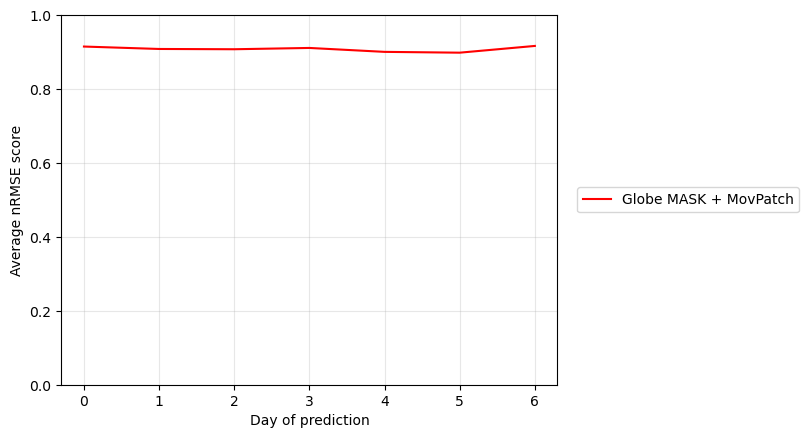

In [10]:
# save_name: named of saved graph if not None
plot_results(RMSE_array,
             save_name=None,
             plot_baked=False,
             vmin=0.,
             vmax=1.,
             name='Globe MASK + MovPatch')